# Surrogate Models and Reason Codes using LOCO

# License 

Copyright 2017 J. Patrick Hall, jphall@gwu.edu

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

#### Python imports

In [1]:
# imports

# h2o Python API with specific classes
import h2o                                        
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.backend import H2OLocalServer

import numpy as np   # array, vector, matrix calculations
import pandas as pd  # DataFrame handling

# system packages for calling external graphviz processes
import os
import re
import subprocess

# in-notebook display
from IPython.display import Image
from IPython.display import display
%matplotlib inline

#### Start h2o

In [2]:
h2o.init()       # start h2o
h2o.remove_all() # remove any existing data structures

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_112"; Java(TM) SE Runtime Environment (build 1.8.0_112-b16); Java HotSpot(TM) 64-Bit Server VM (build 25.112-b16, mixed mode)
  Starting server from /Users/phall/anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmp_ghya7xp
  JVM stdout: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmp_ghya7xp/h2o_phall_started_from_python.out
  JVM stderr: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmp_ghya7xp/h2o_phall_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster version:,3.14.0.2
H2O cluster version age:,1 month and 4 days
H2O cluster name:,H2O_from_python_phall_hgx9gz
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


## 1. Download, explore, and prepare UCI credit card default data

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input variables: 

* **LIMIT_BAL**: Amount of given credit (NT dollar)
* **SEX**: 1 = male; 2 = female
* **EDUCATION**: 1 = graduate school; 2 = university; 3 = high school; 4 = others 
* **MARRIAGE**: 1 = married; 2 = single; 3 = others
* **AGE**: Age in years 
* **PAY_0, PAY_2 - PAY_6**: History of past payment; PAY_0 = the repayment status in September, 2005; PAY_2 = the repayment status in August, 2005; ...; PAY_6 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **BILL_AMT1 - BILL_AMT6**: Amount of bill statement (NT dollar). BILL_AMNT1 = amount of bill statement in September, 2005; BILL_AMT2 = amount of bill statement in August, 2005; ...; BILL_AMT6 = amount of bill statement in April, 2005. 
* **PAY_AMT1 - PAY_AMT6**: Amount of previous payment (NT dollar). PAY_AMT1 = amount paid in September, 2005; PAY_AMT2 = amount paid in August, 2005; ...; PAY_AMT6 = amount paid in April, 2005. 

These 23 input variables are used to predict the target variable, whether or not a customer defaulted on their credit card bill in late 2005.

Because H2O accepts both numeric and character inputs, some variables will be recoded into more transparent character values.

#### Download data and clean

In [3]:
# download XLS file from UCI data repositoty URL
path = 'default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1)

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 

#### Assign modeling roles

In [4]:
# assign target and inputs for GBM
y = 'DEFAULT_NEXT_MONTH'
X = [name for name in data.columns if name not in [y, 'ID']]
print('y =', y)
print('X =', X)

y = DEFAULT_NEXT_MONTH
X = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


#### Helper function for recoding values in the UCI credict card default data

In [5]:
def recode_cc_data(frame):
    
    """ Recodes numeric categorical variables into categorical character variables
    with more transparent values. 
    
    Args:
        frame: Pandas DataFrame version of UCI credit card default data.
        
    Returns: 
        Pandas DataFrame with recoded values.
        
    """
    
    # define recoded values
    sex_dict = {1:'male', 2:'female'}
    education_dict = {0:'other', 1:'graduate school', 2:'university', 3:'high school', 
                      4:'other', 5:'other', 6:'other'}
    marriage_dict = {0:'other', 1:'married', 2:'single', 3:'divorced'}
    pay_dict = {-2:'no consumption', -1:'pay duly', 0:'use of revolving credit', 1:'1 month delay', 
                2:'2 month delay', 3:'3 month delay', 4:'4 month delay', 5:'5 month delay', 6:'6 month delay', 
                7:'7 month delay', 8:'8 month delay', 9:'9+ month delay'}
    
    # recode values using Pandas apply() and anonymous function
    frame['SEX'] = frame['SEX'].apply(lambda i: sex_dict[i])
    frame['EDUCATION'] = frame['EDUCATION'].apply(lambda i: education_dict[i])    
    frame['MARRIAGE'] = frame['MARRIAGE'].apply(lambda i: marriage_dict[i]) 
    for name in frame.columns:
        if name in ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
            frame[name] = frame[name].apply(lambda i: pay_dict[i])            
                
    return frame

data = recode_cc_data(data)

#### Convert from Pandas DataFrame to H2OFrame

In [6]:
data = h2o.H2OFrame(data)    # convert 
data[y] = data[y].asfactor() # ensure target is handled as a categorical variable

Parse progress: |█████████████████████████████████████████████████████████| 100%


#### Display descriptive statistics

In [7]:
data[X + [y]].describe()

Rows:30000
Cols:24




,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
type,int,enum,enum,enum,int,enum,enum,enum,enum,enum,enum,int,int,int,int,int,int,int,int,int,int,int,int,enum
mins,10000.0,,,,21.0,,,,,,,-165580.0,-69777.0,-157264.0,-170000.0,-81334.0,-339603.0,0.0,0.0,0.0,0.0,0.0,0.0,
mean,167484.32266666688,,,,35.48549999999994,,,,,,,51223.33090000009,49179.07516666668,47013.15479999971,43262.9489666666,40311.40096666653,38871.76039999991,5663.580500000014,5921.16350000001,5225.681500000005,4826.076866666661,4799.387633333302,5215.502566666664,
maxs,1000000.0,,,,79.0,,,,,,,964511.0,983931.0,1664089.0,891586.0,927171.0,961664.0,873552.0,1684259.0,896040.0,621000.0,426529.0,528666.0,
sigma,129747.66156720225,,,,9.21790406809016,,,,,,,73635.86057552959,71173.76878252836,69349.38742703681,64332.85613391641,60797.1557702648,59554.10753674574,16563.280354025763,23040.870402057226,17606.961469803115,15666.159744031993,15278.305679144793,17777.465775435332,
zeros,0,,,,0,,,,,,,2008,2506,2870,3195,3506,4020,5249,5396,5968,6408,6703,7173,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,20000.0,female,university,married,24.0,2 month delay,2 month delay,pay duly,pay duly,no consumption,no consumption,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,female,university,single,26.0,pay duly,2 month delay,use of revolving credit,use of revolving credit,use of revolving credit,2 month delay,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,female,university,single,34.0,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0


## 2. Train an H2O GBM classifier

#### Split data into training and test sets for early stopping

In [8]:
# split into training and validation
train, test = data.split_frame([0.7], seed=12345)

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 21060, columns = 25
Test data rows = 8940, columns = 25


In [9]:
# initialize GBM model
model = H2OGradientBoostingEstimator(ntrees=150,            # maximum 150 trees in GBM
                                     max_depth=4,           # trees can have maximum depth of 4
                                     sample_rate=0.9,       # use 90% of rows in each iteration (tree)
                                     col_sample_rate=0.9,   # use 90% of variables in each iteration (tree)
                                     balance_classes=True,  # sample to balance 0/1 distribution of target - helps LOCO
                                     stopping_rounds=5,     # stop if validation error does not decrease for 5 iterations (trees)
                                     seed=12345)            # random seed for reproducibility

# train a GBM model
model.train(y=y, x=X, training_frame=train, validation_frame=test)

# print AUC
print('GBM Test AUC = %.2f' % model.auc(valid=True))

# uncomment to see model details
# print(model) 

gbm Model Build progress: |███████████████████████████████████████████████| 100%
GBM Test AUC = 0.78


#### Display variable importance

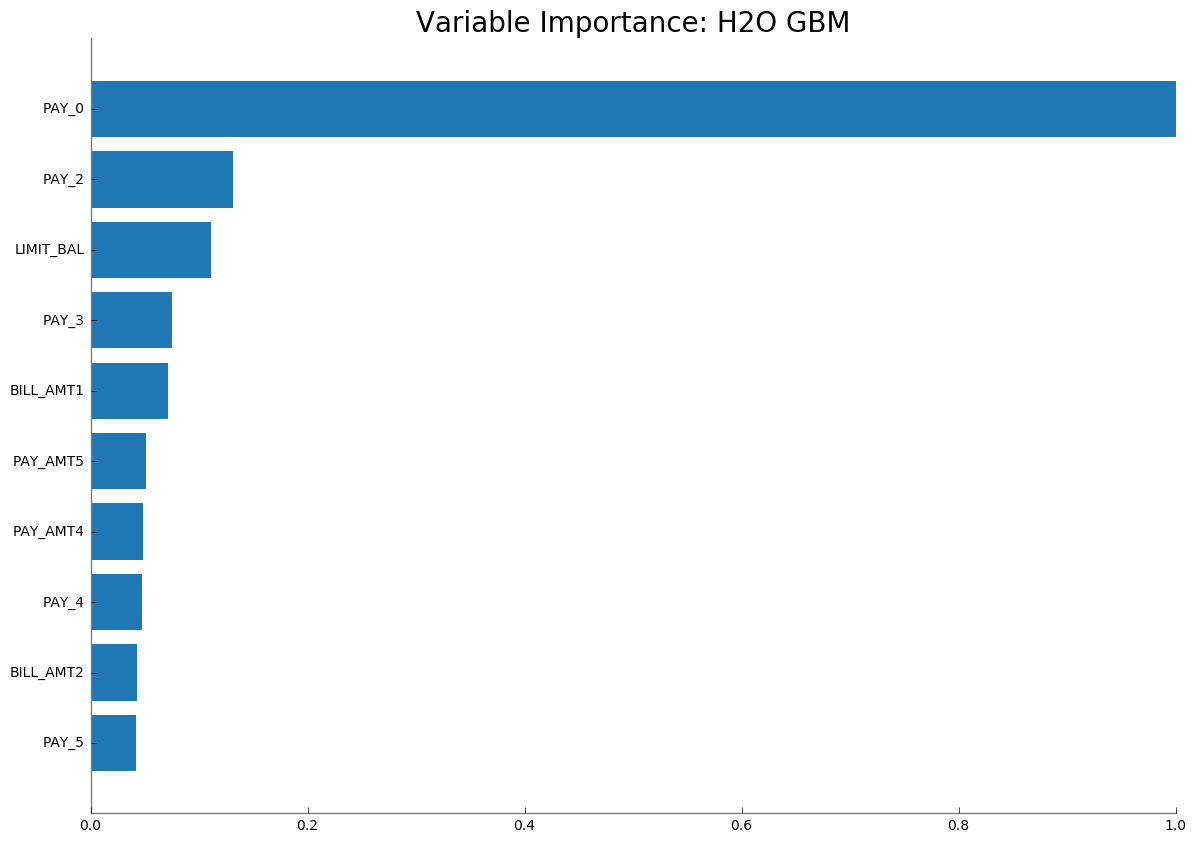

In [10]:
model.varimp_plot()

## 3. Train a decision tree surrogate model to describe GBM

In [11]:
# cbind predictions to training frame
# give them a nice name
yhat = 'p_DEFAULT_NEXT_MONTH'
preds1 = test['ID'].cbind(model.predict(test).drop(['predict', 'p0']))
preds1.columns = ['ID', yhat]
test_yhat = test.cbind(preds1[yhat])

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [12]:
model_id = 'dt_surrogate_mojo' # gives MOJO artifact a recognizable name

# initialize single tree surrogate model
surrogate = H2ORandomForestEstimator(ntrees=1,          # use only one tree
                                     sample_rate=1,     # use all rows in that tree
                                     mtries=-2,         # use all columns in that tree
                                     max_depth=3,       # shallow trees are easier to understand
                                     seed=12345,        # random seed for reproducibility
                                     model_id=model_id) # gives MOJO artifact a recognizable name

# train single tree surrogate model
surrogate.train(x=X, y=yhat, training_frame=test_yhat)

# persist MOJO (compiled, representation of trained model)
# from which to generate plot of surrogate
mojo_path = surrogate.download_mojo(path='.')
print('Generated MOJO path:\n', mojo_path)

drf Model Build progress: |███████████████████████████████████████████████| 100%
Generated MOJO path:
 /Users/phall/workspace/Interpretable-machine-learning-with-Python-XGBoost-and-H2O/dt_surrogate_mojo.zip


In [13]:
# title for plot
title = 'Credit Card Default Decision Tree Surrogate'  

# locate h2o jar
hs = H2OLocalServer()
h2o_jar_path = hs._find_jar()
print('Discovered H2O jar path:\n', h2o_jar_path)

# construct command line call to generate graphviz version of 
# surrogate tree see for more information: 
# http://docs.h2o.ai/h2o/latest-stable/h2o-genmodel/javadoc/index.html
gv_file_name = model_id + '.gv'
gv_args = str('-cp ' + h2o_jar_path +
              ' hex.genmodel.tools.PrintMojo --tree 0 -i '
              + mojo_path + ' -o').split()
gv_args.insert(0, 'java')
gv_args.append(gv_file_name)
if title is not None:
    gv_args = gv_args + ['--title', title]
    
# call 
print()
print('Calling external process ...')
print(' '.join(gv_args))
_ = subprocess.call(gv_args)

Discovered H2O jar path:
 /Users/phall/anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /Users/phall/anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /Users/phall/workspace/Interpretable-machine-learning-with-Python-XGBoost-and-H2O/dt_surrogate_mojo.zip -o dt_surrogate_mojo.gv --title Credit Card Default Decision Tree Surrogate


In [14]:
# contruct call to generate PNG from 
# graphviz representation of the tree
png_file_name = model_id + '.png'
png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
png_args = png_args.split()

# call
print('Calling external process ...')
print(' '.join(png_args))
_ = subprocess.call(png_args)

Calling external process ...
dot -Tpng dt_surrogate_mojo.gv -o dt_surrogate_mojo.png


#### Plot tree in notebook

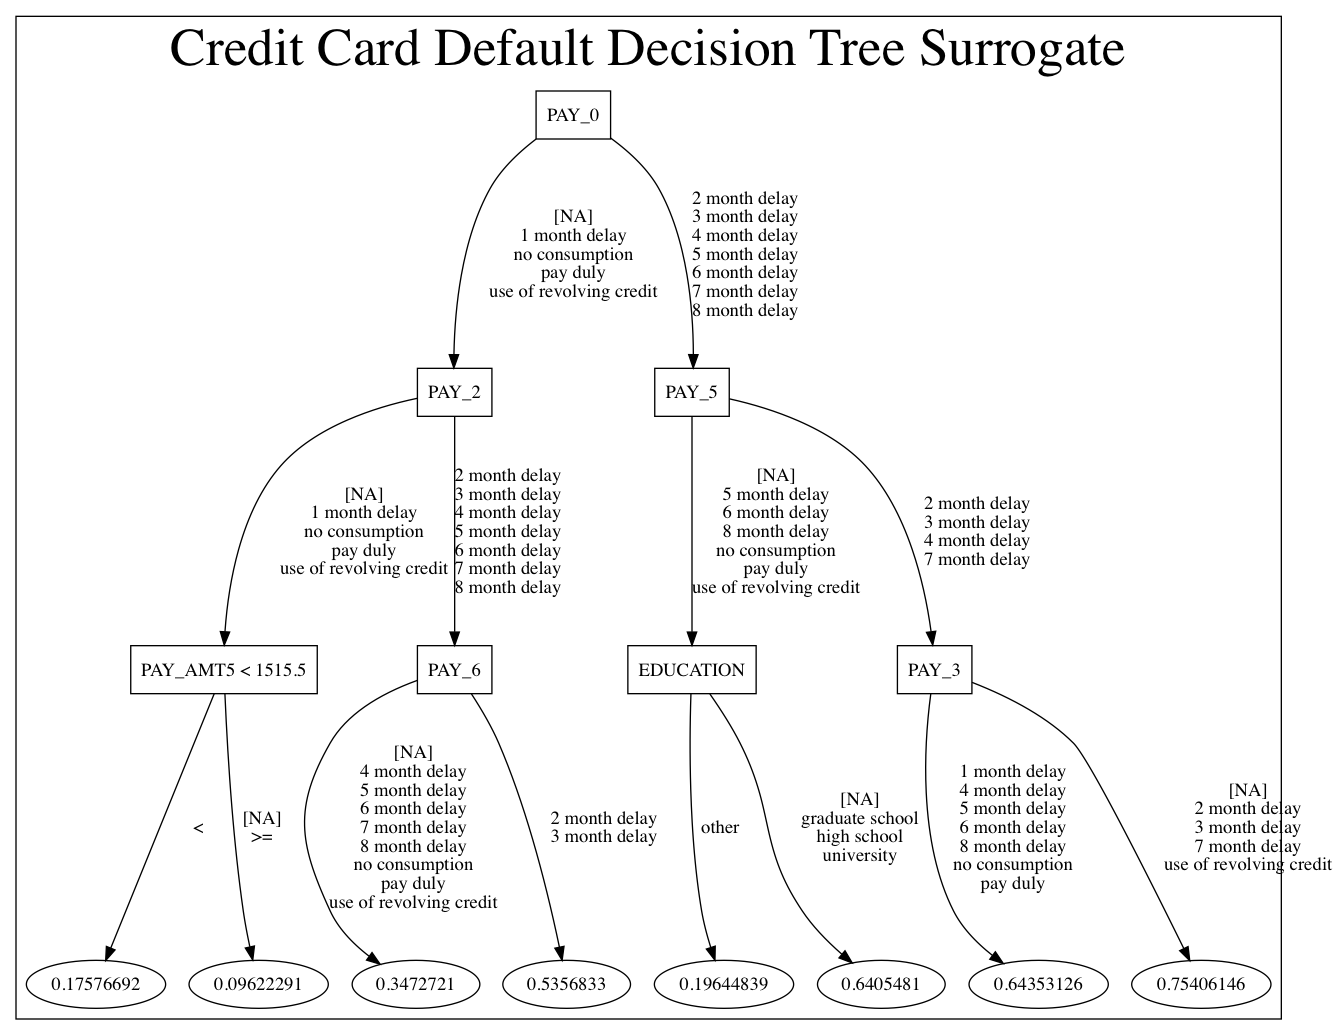

In [15]:
display(Image((png_file_name)))

## 4. Compare global GBM variable importance and decision tree surrogate model

## 5. Generate reason codes using the LOCO method 

* Rescore predictive model
* Each time leaving one input (covariate) out by setting it to missing
* To generate local feature importance values for each decision

Based on: Lei, Jing, G’Sell, Max, Rinaldo, Alessandro, Tibshirani, Ryan J., and Wasserman, Larry. Distribution-free predictive inference for regression. *Journal of the American Statistical Association*, 2017.

http://www.stat.cmu.edu/~ryantibs/papers/conformal.pdf

** Instead of dropping one variable and retraining a model to understand the importance of that variable in a model, these examples set a variable to missing and rescore the this new, corruptes sample with original model. This is liley more appropriate for nonlineaer models in which nonlinear dependencies can allow variables to nearly completely replace one another when a model is retrained. **

#### Calculate LOCO reason values for each row of the test set

In [16]:
h2o.no_progress() # turn off h2o gratuitous progress bars

# create set of original predictions and row ID
preds2 = test['ID'].cbind(model.predict(test).drop(['predict', 'p0']))
preds2.columns = ['ID', 'p_DEFAULT_NEXT_MONTH']

# calculate LOCO for each variable
for k, i in enumerate(X):

    # train and predict with Xi set to missing
    test_loco = h2o.deep_copy(test, 'test_loco')
    test_loco[i] = np.nan
    preds_loco = model.predict(test_loco).drop(['predict','p0'])
    
    # create a new, named column for the LOCO prediction
    preds_loco.columns = [i]
    preds2 = preds2.cbind(preds_loco)
    
    # subtract the LOCO prediction from the original prediction
    preds2[i] = preds2['p_DEFAULT_NEXT_MONTH'] - preds2[i]
    
    # update progress
    print('LOCO Progress: ' + i + ' (' + str(k+1) + '/' + str(len(X)) + ') ...')
    
print('Done.')  

preds2.head()

LOCO Progress: LIMIT_BAL (1/23) ...
LOCO Progress: SEX (2/23) ...
LOCO Progress: EDUCATION (3/23) ...
LOCO Progress: MARRIAGE (4/23) ...
LOCO Progress: AGE (5/23) ...
LOCO Progress: PAY_0 (6/23) ...
LOCO Progress: PAY_2 (7/23) ...
LOCO Progress: PAY_3 (8/23) ...
LOCO Progress: PAY_4 (9/23) ...
LOCO Progress: PAY_5 (10/23) ...
LOCO Progress: PAY_6 (11/23) ...
LOCO Progress: BILL_AMT1 (12/23) ...
LOCO Progress: BILL_AMT2 (13/23) ...
LOCO Progress: BILL_AMT3 (14/23) ...
LOCO Progress: BILL_AMT4 (15/23) ...
LOCO Progress: BILL_AMT5 (16/23) ...
LOCO Progress: BILL_AMT6 (17/23) ...
LOCO Progress: PAY_AMT1 (18/23) ...
LOCO Progress: PAY_AMT2 (19/23) ...
LOCO Progress: PAY_AMT3 (20/23) ...
LOCO Progress: PAY_AMT4 (21/23) ...
LOCO Progress: PAY_AMT5 (22/23) ...
LOCO Progress: PAY_AMT6 (23/23) ...
Done.


ID,p_DEFAULT_NEXT_MONTH,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
4,0.143808,0.0395492,0,0,0.00488541,0.00145886,-0.00133072,0,0,0,0,-0.00208479,0.00497314,0,0,0,0,0,0,0,0,0.00396488,0,0.00112525
8,0.115506,0.00235493,0,0,0,-0.000552543,-0.0046544,0,-0.00987235,0.00746337,0.00121049,0.00774774,0.0108731,0,0.00409888,0.000498845,0.00586113,-0.00661647,0,0.00632623,0.0201806,0.00328685,-0.0111833,0
10,0.0699909,-0.090736,0.00130031,-0.00429856,0,0.00123077,-0.00603599,0,-0.0186349,-0.00205016,0,0.0054725,0.00120875,-0.0266242,0,-0.00601172,0,0.0132564,0,-0.00257952,0.0107597,-0.0781254,0,-0.00976274
16,0.365249,0.0346829,0,0,0.0184481,0.0079495,0.137733,0.0426871,-0.0109424,0.000408205,0,-0.00391089,0,0,-0.00386402,0,0,0,0,0.000457324,0,0,0,0
17,0.445295,0.0193616,0.00497161,0.0047161,0,0.00443013,-0.00319144,0,0.0998863,0.0522704,0.116106,0.0419711,0.0992234,0,-0.0119642,0,0,0,0,0.0149065,0.00638951,0.0224092,0,-0.018557
19,0.457886,0.094326,0,0.00261526,0.000767363,0.0474124,0.11968,-0.0452904,0.00255303,0.0163367,0,0.0185373,0.0666047,0.027194,0.011298,0,0.0243838,0,0,0.0330955,0.0722033,0.0331551,0.12266,0.0486447
22,0.275117,0.0103907,0,0,0.009787,0.016347,0.0562924,0,-0.0007653,-0.00550297,0,0.0170607,0.10094,0,0.00805269,0.00588173,0.0115468,0.00207064,0,0.00838001,0.0332192,0.0231593,0.0328441,0.0167603
30,0.137129,0.0292158,0.00236688,-0.00442867,0,-0.0012295,-0.00153491,0,0,0.0107908,0.00140232,0,0.0166292,0,-0.00961898,0,0,-0.00267912,0,0.0109306,0,0.00380941,0,0.00740615
32,0.634661,-0.00203064,0.00468472,0,0,0,0.508308,0,0,0.000408442,0,0,0.0156802,-0.0182023,-0.0276013,0,0,0,0,0.00286074,0,0,0,-0.00115016
37,0.0786513,-0.0245874,0.00255497,-0.00196108,0.0145092,0.0080562,-0.00022121,0,0,0,0,-0.00122834,0.0195793,0.00661023,0.00202364,0,0.00209357,-0.00660156,0.00186888,-0.00208518,0,-0.00123938,-0.00662392,0.00077543


The numeric values in each column are an estimate of how much each variable contributed to each decision. These values can tell you how a variable and it's values were weighted in any given decision by the model. These values are crucially important for machine learning interpretability and are often to referred to "local feature importance", "reason codes", or "turn-down codes." The latter phrases are borrowed from credit scoring. Credit lenders must provide reasons for turning down a credit application, even for automated decisions. Reason codes can be easily extracted from LOCO local feature importance values, by simply ranking the variables that played the largest role in any given decision.

#### Helper function for finding quantile indices

In [17]:
def get_percentile_dict(yhat, id_, frame):

    """ Returns the percentiles of a column, yhat, as the indices based on 
        another column id_.
    
    Args:
        yhat: Column in which to find percentiles.
        id_: Id column that stores indices for percentiles of yhat.
        frame: Pandas DataFrame containing yhat and id_. 
    
    Returns:
        Dictionary of percentile values and index column values.
    
    """
    
    # convert to Pandas and sort 
    sort_df = frame.as_data_frame()
    sort_df.sort_values(yhat, inplace=True)
    sort_df.reset_index(inplace=True)

    # find top and bottom percentiles
    percentiles_dict = {}
    percentiles_dict[0] = sort_df.loc[0, id_]
    percentiles_dict[99] = sort_df.loc[sort_df.shape[0]-1, id_]
    inc = sort_df.shape[0]//10
    
    # find 10th-90th percentiles    
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc,  id_]

    return percentiles_dict


In [18]:
# display percentiles dictionary
# ID values for rows
# from lowest prediction 
# to highest prediction
percentile_dict = get_percentile_dict('p_DEFAULT_NEXT_MONTH', 'ID', preds2)
percentile_dict

{0: 14759,
 10: 11886,
 20: 22630,
 30: 12872,
 40: 23871,
 50: 1426,
 60: 15393,
 70: 7806,
 80: 8625,
 90: 1846,
 99: 22760}

#### Plot some reason codes for a risky customer

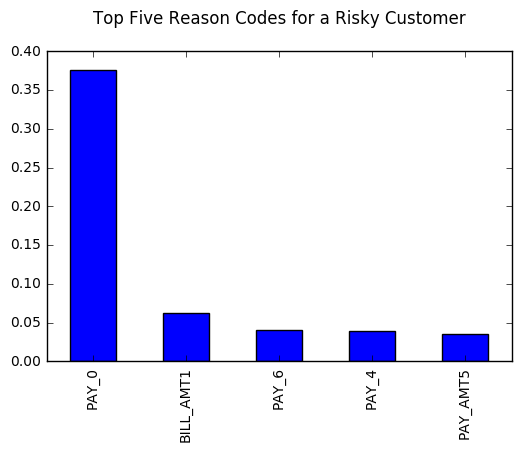

In [19]:
risky_loco = preds2[preds2['ID'] == int(percentile_dict[99]), :] # select single customer
             .as_data_frame()                                    # convert to Pandas
             .drop(['ID', 'p_DEFAULT_NEXT_MONTH'], axis=1)       # drop prediction and row ID

# transpose into column vector and sort        
risky_loco = risky_loco.T.sort_values(by=0, ascending=False)[:5]

# plot
_ = risky_loco.plot(kind='bar', 
                    title='Top Five Reason Codes for a Risky Customer\n', 
                    legend=False)

#### Display customer in question 

In [20]:
test_yhat[test_yhat['ID'] == int(percentile_dict[99]), :] # helps understand reason codes

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH
22760,460000,female,graduate school,married,40,3 month delay,2 month delay,2 month delay,3 month delay,3 month delay,3 month delay,2650,2650,2650,2650,2650,2650,0,0,0,0,0,200,1,0.89088


## 6. Generate ensemble LOCO reason codes for greater explanation stability
Explanations derived from high variance machine learning models can be unstable. One general way to decrease variance is to ensemble the results of many models.

#### Train multiple models

In [21]:
n_models = 5 # select number of models

# lists for holding models and predictions
models = []
pred_frames = []

for i in range(0, n_models):

    # initialize and store models
    models.append(H2OGradientBoostingEstimator(ntrees=150,
                                               max_depth=4,
                                               sample_rate=0.9 - ((i + 1)*0.01),     # perturb sample rate
                                               col_sample_rate=0.9 - ((i + 1)*0.01), # perturb column sample rate
                                               balance_classes=True,                 # sample to balance 0/1 distribution of target - helps LOCO
                                               stopping_rounds=5,                    # stop if validation error does not decrease for 5 iterations (trees)
                                               seed=i + 1))                          # new random seed for each model
    
    # train models
    models[i].train(y=y, x=X, training_frame=train, validation_frame=test)
    
    # store predictions
    pred_frames.append(test['ID'].cbind(models[i].predict(test).drop(['predict','p0'])))
    pred_frames[i].columns = ['ID', 'p_DEFAULT_NEXT_MONTH']
    
    # update progress
    print('Training Progress: model %d/%d, AUC = %.4f ...' % (i + 1, n_models, models[i].auc(valid=True)))

print('Done.')

Training Progress: model 1/5, AUC = 0.7830 ...
Training Progress: model 2/5, AUC = 0.7808 ...
Training Progress: model 3/5, AUC = 0.7824 ...
Training Progress: model 4/5, AUC = 0.7827 ...
Training Progress: model 5/5, AUC = 0.7804 ...
Done.


#### Calculate LOCO for each model

In [22]:
# for each new model ...
for k, model in enumerate(models):

    # calculate LOCO for each input variable 
    for i in X:

        # train and predict with Xi set to missing
        test_loco = h2o.deep_copy(test, 'test_loco')
        test_loco[i] = np.nan
        preds_loco = model.predict(test_loco).drop(['predict','p0'])

        # create a new, named column for the LOCO prediction
        preds_loco.columns = [i]
        pred_frames[k] = pred_frames[k].cbind(preds_loco)

        # subtract the LOCO prediction from the original prediction
        pred_frames[k][i] = pred_frames[k]['p_DEFAULT_NEXT_MONTH'] - pred_frames[k][i]
        
    # update progress    
    print('LOCO Progress: model %d/%d ...' % (k + 1, n_models))

print('Done.')

LOCO Progress: model 1/5 ...
LOCO Progress: model 2/5 ...
LOCO Progress: model 3/5 ...
LOCO Progress: model 4/5 ...
LOCO Progress: model 5/5 ...
Done.


#### Collect LOCO values for each model for a risky customer

In [23]:
# holds predictions for a specific row 
risky_loco_frames = []

# column names for Pandas DataFrame of combined LOCO prediction
col_names = ['Loco ' + str(i) for i in range(1, n_models + 1)]

# for each new model ...
for i in range(0, n_models):
    
    # collect LOCO for that model and a specific row 
    # as a column vector in a Pandas DataFrame
    preds = pred_frames[i]
    risky_loco_frames.append(preds[preds['ID'] == int(percentile_dict[99]), :] # row for risky person
                             .as_data_frame()                                  # convert to Pandas
                             .drop(['ID', 'p_DEFAULT_NEXT_MONTH'], axis=1)     # drop predictions and row ID
                             .T)                                               # Transpose into column vector

# bind LOCO for each row as column vectors 
# into the same Pandas DataFrame
loco_ensemble = pd.concat(risky_loco_frames, axis=1) 

# update column names
loco_ensemble.columns = col_names
loco_ensemble['Mean Local Importance'] = loco_ensemble.mean(axis=1)
loco_ensemble['Std. Dev. Local Importance'] = loco_ensemble.std(axis=1)

# display
loco_ensemble

,Loco 1,Loco 2,Loco 3,Loco 4,Loco 5,Mean Local Importance,Std. Dev. Local Importance
LIMIT_BAL,0.008224,-0.002825,0.005422,0.001675,0.003964,0.003292,0.003724
SEX,0.003280,0.000000,0.000000,0.000000,0.000000,0.000656,0.001312
EDUCATION,0.000782,-0.001000,0.003249,0.000856,0.009470,0.002671,0.003658
MARRIAGE,0.015760,-0.015096,0.017120,-0.001306,0.004459,0.004187,0.011860
AGE,0.002046,0.002258,0.018536,0.010835,0.027602,0.012256,0.009810
PAY_0,0.250520,0.231620,0.194381,0.211153,0.149160,0.207367,0.034703
PAY_2,0.015101,0.059999,0.053539,0.040156,0.109746,0.055708,0.031093
PAY_3,0.011597,0.011972,0.006794,0.005228,-0.005805,0.005957,0.006443
PAY_4,0.037904,0.054045,0.053397,0.029248,0.064386,0.047796,0.012550
PAY_5,0.042922,0.008154,0.029185,0.019371,0.027090,0.025344,0.011472


#### Plot some mean reason codes for a risky customer

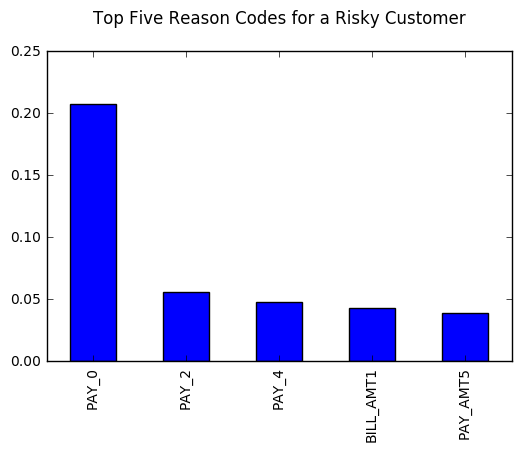

In [24]:
risky_mean_loco = loco_ensemble['Mean Local Importance'].sort_values(ascending=False)[:5]
_ = risky_mean_loco.plot(kind='bar', 
                         title='Top Five Reason Codes for a Risky Customer\n', 
                         legend=False)

#### Shutdown H2O

In [25]:
# be careful, this can erase your work!
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
H2O session _sid_8ec1 closed.
